# Visualization Notebook

This is essentially a diffusion problem, and the partial differential equation that drives this phenomenon for a 2D problem is:

$$ Lap(T) = 0$$
$$or$$
$$\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2} = 0$$ 

#### Imports

In [1]:
import torch.autograd as autograd

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
from FCN import FCN
from tools import *

In [3]:
%matplotlib inline

#### Function tools

In [4]:
def partial_diff_equation(f, g):
    f_x_y = autograd.grad(f,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True)[0] #first derivative
    f_xx_yy = autograd.grad(f_x_y,g,torch.ones(g.shape), create_graph=True)[0]#second derivative

    f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
    f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

    u = f_xx + f_yy # loss equation
    u = u.float()

    return u

In [5]:
def pplot(u_pred,lossTensor, num_ticks = 11, mask = np.full((500, 500), False)):
    plt.close()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
    fig.tight_layout(pad = 5)

    num_ticks = 11
    # number of points in x and y
    nx = len(x)
    ny = len(y)
    # the index of the position of yticks
    yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)

    fmt = lambda x, pos: '{:.2f}'.format(x/nx, pos)

    sns.heatmap(u_pred, 
                ax = ax1, 
                cmap = "rocket_r",
                cbar_kws={'label': r'$T^*$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    ax1.invert_yaxis()
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)

    ax1.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax1.set_title('Temperature')

    minLoss = np.percentile(lossTensor, 5)
    maxLoss = np.percentile(lossTensor, 95)

    # rounds up value to the next multiple of 0.05
    value = ((max(abs(minLoss), abs(maxLoss)) + 0.049)//(0.05))*0.05

    sns.heatmap(lossTensor,
                ax = ax2,
                vmin = -value,
                vmax = value,
                cmap = "vlag_r",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    ax2.invert_yaxis()
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)

    ax2.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax2.set_title('Loss')

    plt.show()

## 1. Simplest Case

##### Hypotheses:
1. Stationary 2D problem
2. Geometry: simple square of side 1 with circular hole of radius $R = 0.1$
3. No internal heat generation or dissipation

##### Boundary Conditions:
1. Dirichlet:  $T^*(x = 0) = 0$ , $T^*(x = 1) = 1$

2. Neumann: $\frac{\partial T^*(y = 0)}{\partial y} = \frac{\partial T^*(y = 1)}{\partial y} = 0$

##### Loss function:
The loss function will be calculated as:

$$ Loss_{total} = \frac{N_f}{N_u} Loss_{BC}+ Loss_{PDE}

#### 1.1. Setup and calculation

In [6]:
myProblem = Problem(partial_diff_equation, squareHasHole = False, hasInternalHeat = False, evolutiveWeights= False)

X_train_PDE, X_train_Nu, T_train_Nu, X_test = myProblem.getDomains()

X_train, T_train = myProblem.X_train, myProblem.T_train

x = myProblem.X[:,0]
y = myProblem.Y[0,:]

N_x, N_y = myProblem.N_x, myProblem.N_y

/Users/thyagocapitanio/anaconda3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
PINN = FCN(myProblem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_files/PINN_simple.pt'))

<All keys matched successfully>

In [8]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))

In [9]:
lossTensor = PINN.lossTensor(X_test)
lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x,N_y))

#### 1.2. Graph

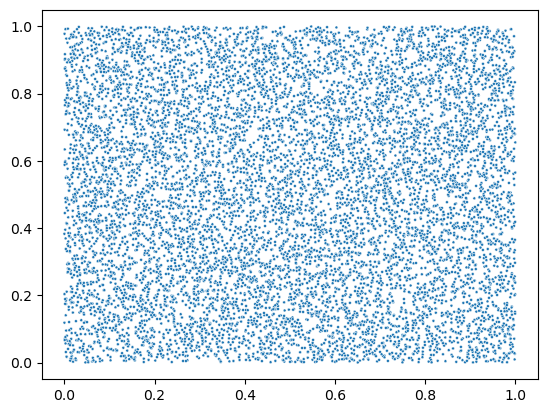

In [12]:
sns.scatterplot(X_train_PDE, x = X_train_PDE[:, 0], y = X_train_PDE[:, 1], marker = ".", size = 1, legend = False)
plt.show()

In [30]:
def pplot2(u_pred,lossTensor, num_ticks = 11, mask = np.full((500, 500), False)):
    plt.close()
    fig, axs = plt.subplots(2, 2, figsize = (12,12))
    fig.tight_layout(pad = 5)

    num_ticks = 11
    # number of points in x and y
    nx = len(x)
    ny = len(y)
    # the index of the position of yticks
    yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)

    fmt = lambda x, pos: '{:.2f}'.format(x/nx, pos)

    sns.heatmap(u_pred, 
                ax = axs[0, 0], 
                cmap = "rocket_r",
                cbar_kws={'label': r'$T^*$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_xticks(xticks)
    axs[0, 0].set_yticks(yticks)

    axs[0, 0].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 0].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 0].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[0, 0].set_title('Temperature')

    minLoss = np.percentile(lossTensor, 5)
    maxLoss = np.percentile(lossTensor, 95)

    # rounds up value to the next multiple of 0.05
    value = ((max(abs(minLoss), abs(maxLoss)) + 0.049)//(0.05))*0.05

    sns.heatmap(lossTensor,
                ax = axs[0, 1],
                vmin = -value,
                vmax = value,
                cmap = "vlag_r",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_xticks(xticks)
    axs[0, 1].set_yticks(yticks)

    axs[0, 1].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 1].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 1].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[0, 1].set_title('Loss')

    sns.scatterplot(X_train_PDE, 
                    x = X_train_PDE[:, 0], 
                    y = X_train_PDE[:, 1], 
                    ax = axs[1, 0],
                    marker = ".",  
                    legend = False)

    axs[1, 0].set_xticks(xticks)
    axs[1, 0].set_yticks(yticks)

    axs[1, 0].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[1, 0].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[1, 0].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[1, 0].set_title('Sampling points for Neural Network')

    sns.heatmap(lossTensor,
                ax = axs[1, 1],
                vmin = -value,
                vmax = value,
                cmap = "vlag_r",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_xticks(xticks)
    axs[1, 1].set_yticks(yticks)

    axs[1, 1].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[1, 1].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[1, 1].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[1, 1].set_title('Loss')

    plt.show()

<Axes: >

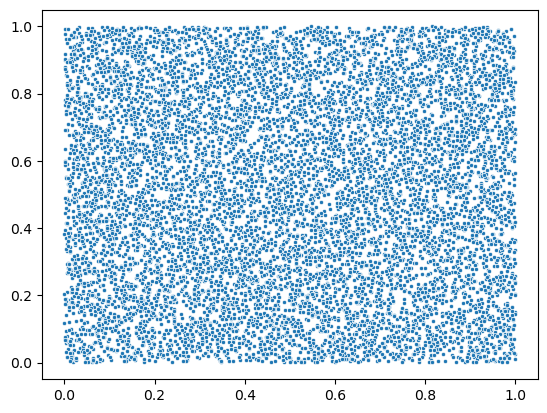

In [29]:
sns.scatterplot(X_train_PDE, 
                    x = X_train_PDE[:, 0], 
                    y = X_train_PDE[:, 1], 
                    marker = ".",  
                    legend = False)

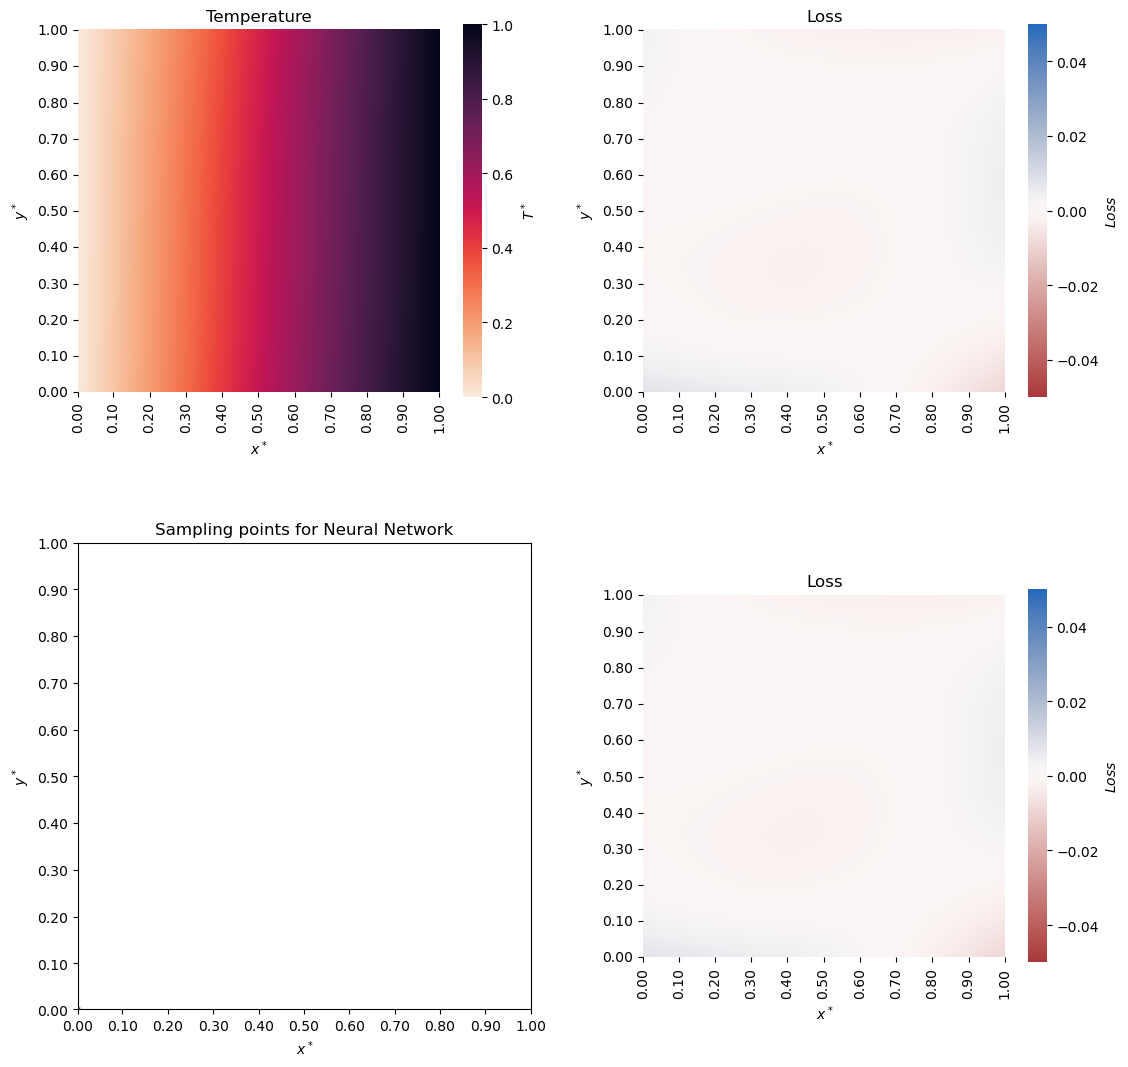

In [31]:
pplot2(u_pred, lossTensor)

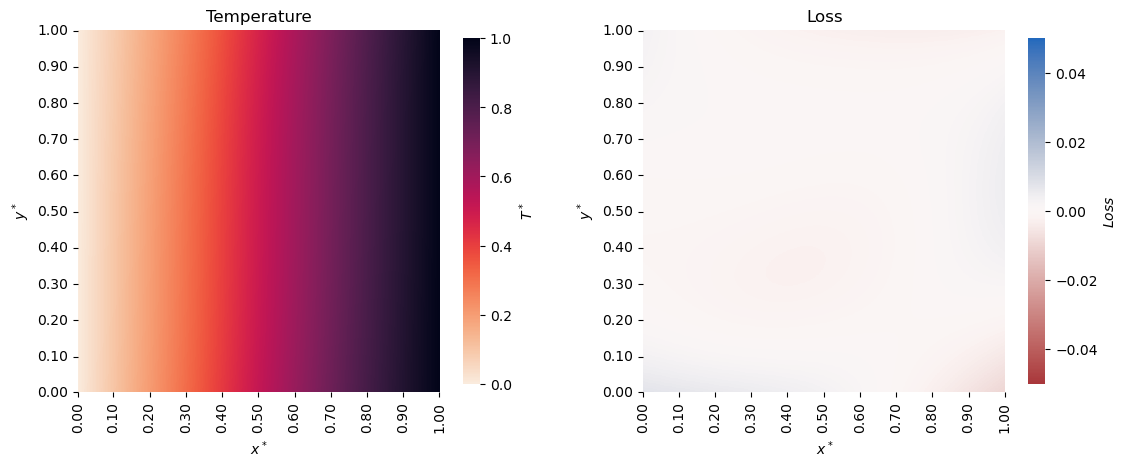

In [ ]:
pplot(u_pred, lossTensor)

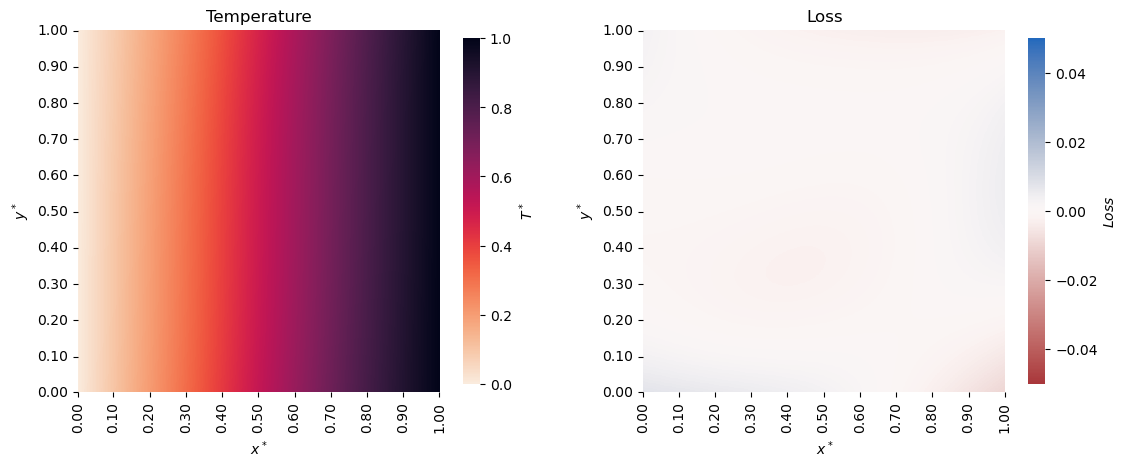

In [12]:
pplot(u_pred, lossTensor)

## 2. Square With Hole

##### Hypotheses:
1. Stationary 2D problem
2. Geometry: simple square of side 1 with circular hole of radius $R = 0.1$ defined by perimeter $\Gamma$
3. No internal heat generation or dissipation

##### Boundary Conditions:
1. Dirichlet:  $\begin{cases}
    T^*(x = 0, y) = 0\\
    T^*(x = 1, y) = 0\\
    T^*(x, y = 0) = 0\\
    T^*(x, y = 1) = 0\\
    T^*(x, y) = 0.5 & , & if (x,y) & \in \Gamma \\
  \end{cases}$

##### Loss function:
The loss function will be calculated as:

$$ Loss_{total} = \frac{N_f}{N_u} Loss_{BC}+ Loss_{PDE}

#### 2.1. Setup and calculation

In [18]:
myProblem = Problem(partial_diff_equation, squareHasHole = True, hasInternalHeat = False, evolutiveWeights= False)

X_train_PDE, X_train_Nu, T_train_Nu, X_test = myProblem.getDomains()

X_train, T_train = myProblem.X_train, myProblem.T_train

x = myProblem.X[:,0]
y = myProblem.Y[0,:]

N_x, N_y = myProblem.N_x, myProblem.N_y

In [22]:
PINN = FCN(myProblem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_files/PINN_wHole.pt'))

<All keys matched successfully>

In [23]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))

In [24]:
lossTensor = PINN.lossTensor(X_test)
lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x,N_y))

In [25]:
mask = myProblem.isNotInCircleTensorOrder2(u_pred, x, y)

#### 2.2. Graph

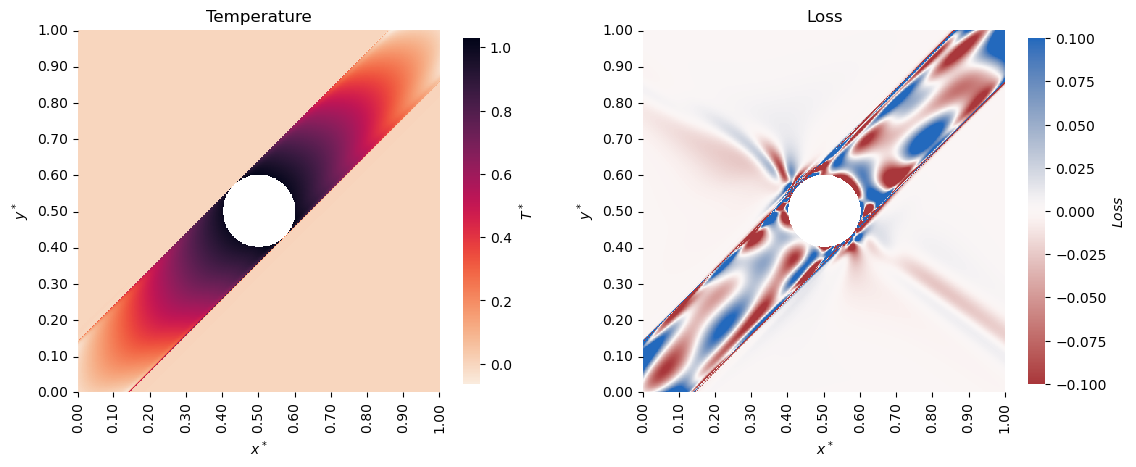

In [26]:
pplot(u_pred, lossTensor, mask = (1 - mask))

## 3. Evolutive Params

##### Hypotheses:
1. Stationary 2D problem
2. Geometry: simple square of side 1 with circular hole of radius $R = 0.1$ defined by perimeter $\Gamma$
3. No internal heat generation or dissipation

##### Boundary Conditions:
1. Dirichlet:  $\begin{cases}
    T^*(x = 0, y) = 0\\
    T^*(x = 1, y) = 0\\
    T^*(x, y = 0) = 0\\
    T^*(x, y = 1) = 0\\
    T^*(x, y) = 0.5 & , & if (x,y) & \in \Gamma \\
  \end{cases}$

##### Loss function:
For $i^* = \frac{current \ number \ of \ iterations}{maximum \ number \ of \ iterations}$, the loss function will be calculated as:

$$ Loss_{total} = \frac{N_f}{N_u} Loss_{BC} (1 - e^{-5i^*})+ Loss_{PDE} * e^{-5i^*}

#### 3.1. Setup and calculation

In [27]:
myProblem = Problem(partial_diff_equation, squareHasHole = True, hasInternalHeat = False, evolutiveWeights= True)
myProblem.setTemp(T_left = 0, T_top = 0, T_right= 0, T_bottom= 0, T_circle= 1)

X_train_PDE, X_train_Nu, T_train_Nu, X_test = myProblem.getDomains()

X_train, T_train = myProblem.X_train, myProblem.T_train

x = myProblem.X[:,0]
y = myProblem.Y[0,:]

N_x, N_y = myProblem.N_x, myProblem.N_y

In [28]:
PINN = FCN(myProblem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_files/PINN_evolutive.pt'))

<All keys matched successfully>

In [29]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))

In [144]:
mask = myProblem.isNotInCircleTensorOrder2(u_pred, x, y)

In [30]:
lossTensor = PINN.lossTensor(X_test)
lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x, N_y))

#### 3.2. Graph

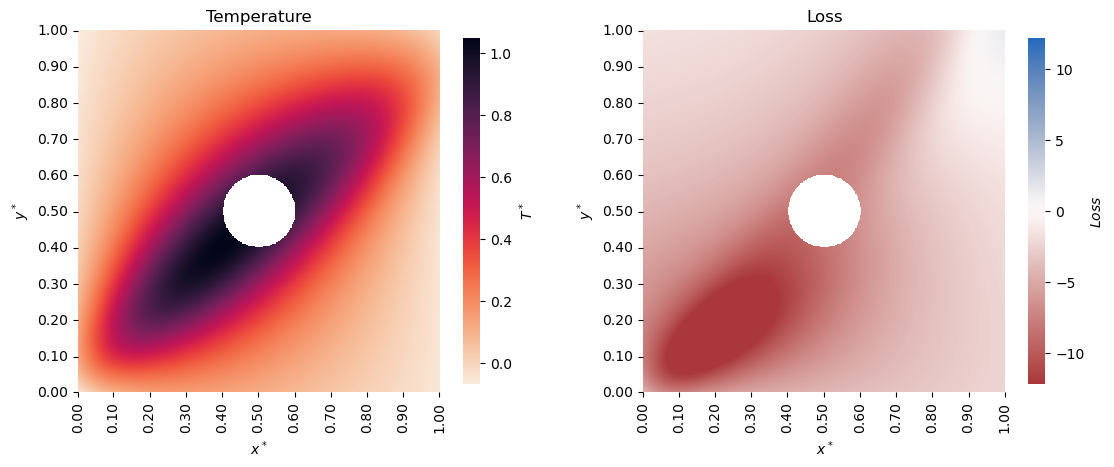

In [31]:
pplot(u_pred, lossTensor, mask = (1 - mask))

## 4. Dirichlet